# Homework 2024-25: Preliminary Design and Verification of Fuel Rod

In [27]:

# Import Necessary Libraries
import numpy as np
import sympy as sp
import matplotlib.pyplot as plt
import functions as f
import math
from IPython.display import display, Math

In [28]:
####################################
# MATERIAL PROPERTIES
####################################
class Material_Proprieties:
        def __init__(self, Elem, Qual):
            self.Elements = Elem
            self.Qualities = Qual

# Cladding Composition (wt.%)
# cr_content = 15.0
# ni_content = 15.0
# mo_content = 1.5
# mn_content = 1.5
# si_content = 0.9
# ti_content = 0.4
# c_content = 0.09
# b_content_ppm = 60
Cladding_mat_prop = Material_Proprieties(
    Elem = ["Cr", "Ni", "Mo", "Mn", "Si", "Ti", "C", "B [ppm]"],
    Qual = [15, 15, 1.5, 1.5, 0.9, 0.4, 0.09, 60],
)

# Data for Material Composition
# uranium_composition = "Natural composition"
# plutonium_content = 0.29  # wt.%
Fuel_mat_prop = Material_Proprieties(
    Elem = ["U-235", "U-238", "O-16", "Pu"],
    Qual = [0.711 * (1-0.29), (1-0.711) * (1-0.29), 2, 0.29] # To fix since 0.29 is in weight
)

In [ ]:

# Data for Fuel Pin Specifications
fuel_material = "Homogeneous MOX"
fuel_column_height = 850  # mm
fuel_pellet_outer_diameter = 5.42  # mm
fuel_pellet_height = 7  # mm
fuel_theoretical_density = 11.31  # g/cm^3
fuel_density_percent_td = 94.5  # %
fuel_grain_diameter = 10  # μm
oxygen_to_metal_ratio = 1.957
cladding_material = "15-15, Ti stabilized, cold worked stainless steel"
cladding_outer_diameter = 6.55  # mm
filling_gas = "He"
initial_pressure_filling_gas = 0.1  # MPa
initial_temperature_filling_gas = 20  # °C

# Data for Neutronic Specifications
neutron_flux_peak = 6.1  # Neutron Flux (> 100 keV) (10^15 n cm^-2 s^-1) at Peak Power Node

# Data for Thermo-Hydraulic Specifications
pin_pitch = 8.275  # mm
coolant_inlet_temp = 395  # °C
coolant_inlet_pressure = 0.1  # MPa
coolant_mass_flow_rate = 0.049  # kg/s

# Filling Gas Composition
he_content = 100  # %

# Data for Axial Nodalization of the Fuel Pin
node_numbers = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
heights_of_slice_centre = [42.5, 127.5, 212.5, 297.5, 382.5, 467.5, 552.5, 637.5, 722.5, 807.5]  # mm
peak_factors = [0.572, 0.737, 0.868, 0.958, 1, 0.983, 0.912, 0.802, 0.658, 0.498]

# Data for Material Properties
# Fuel Properties
fuel_melting_temp = lambda pu, x, beta: 2964.92 + ((3147 - 364.85 * pu - 1014.15 * x) - 2964.92) * math.exp(-beta)
thermal_conductivity = lambda k_inf, beta: 1.755 + (k_inf - 1.755) * math.exp(-beta)
linear_thermal_expansion_coeff = 1.2e-5  # 1/°C
youngs_modulus_fuel = lambda t, p: (22.43 * 10**4 - 31.19 * t) * (1 - 2.6 * p)  # MPa
poissons_ratio_fuel = 0.32
swelling_strain_fuel = lambda beta: 0.07 * beta  # %

# Cladding Properties
cladding_melting_temp = 1673  # K
linear_thermal_expansion_cladding = lambda t: -3.101e-4 + 1.545e-5 * t + 2.75e-9 * t**2
density_cladding = lambda eth: 7900 * (1 + eth)**-3  # kg/m^3
thermal_conductivity_cladding = lambda t: 13.95 + 0.01163 * t  # W/m K
youngs_modulus_cladding = lambda t: 202.7 - 0.08167 * t  # GPa
poissons_ratio_cladding = lambda t: 0.277 + 6e-5 * t
yield_stress_cladding = lambda t: 555.5 - 0.25 * t if t < 600 else (405.5 - 0.775 * (t - 600) if t < 1000 else 345.5 - 0.25 * t)  # MPa
ultimate_tensile_strength = lambda t: 700 - 0.3125 * t if t < 600 else (512.5 - 0.969 * (t - 600) if t < 1000 else 437.5 - 0.3125 * t)  # MPa
rupture_strain = lambda t: 8 + 4.74e-3 * (t - 500) + 6.2e-5 * (t - 500)**2  # %
void_swelling = lambda t: 1.5e-4 * math.exp(-2.5 * (t - 450) / 100)  # %

# Coolant Properties
coolant_melting_temp = 98  # °C
coolant_boiling_temp = 882  # °C
isobaric_specific_heat = lambda t: 1608 - 0.7481 * t + 3.929e-4 * t**2  # J/kg K
density_coolant = lambda t_f: 954.1579 + t_f * (t_f * (0.9667e-9 - 0.46e-5) - 0.1273534)  # kg/m^3
dynamic_viscosity_coolant = lambda t: math.exp(-2.530 + -234.48 / t)  # mPa s
thermal_conductivity_coolant = lambda t: 110 - 0.0648 * t + 1.16e-5 * t**2  # W/m K
nusselt_number = lambda pe: 7 + 0.025 * pe**0.8

# Filling Gas Thermal Conductivity
thermal_conductivity_he = lambda t: 15.8e-4 * t**0.79  # W/m K

# Data for Indicative Design Limits
max_fuel_temp = 2600  # °C
max_cladding_temp = 650  # °C
max_plenum_pressure = 5  # MPa
max_cladding_plastic_strain = 0.5  # %
max_cladding_swelling = 3  # %
max_coolant_velocity = 8  # m/s


## Thermal - Hydraulics Analysis
Done:
- Power Profile and Peak Power  
- Velocity of the flow 
- suca

In [34]:
# Velocity and Passage Area Calculation
# To be modified with a proper evaluation
density = density_coolant(395)
display(Math(r'\rho_{coolant} =' + f'{density:.2f}' + r'\text{ kg/m}^3' ))
velocity, passage_area= f.hydraulic_flow(coolant_mass_flow_rate, density, pin_pitch*1e-3, cladding_outer_diameter*1e-3)
display(Math(r'v_{coolant} =' + f'{velocity:.2f}' + r'\text{ m/s}' ))
display(Math(r'A_{passage} =' + f'{passage_area*1e6:.2f}' + r'\text{ mm}^2' ))


<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

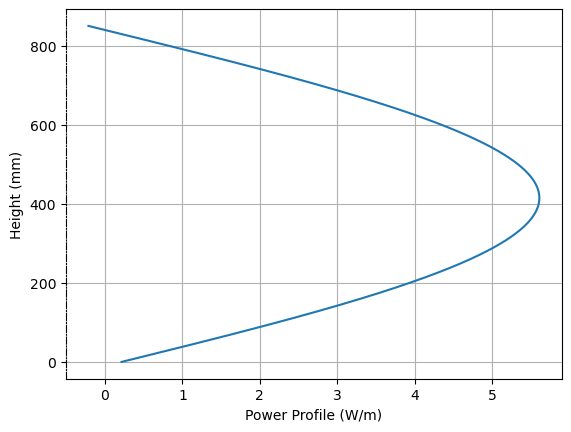

In [30]:
# Plotting the Axial Power Profile
power_profile = f.power_profile(1, heights_of_slice_centre, peak_factors, 850)
z_plot = np.linspace(0, 850, 1000)
power_plot = power_profile(z_plot)
plt.plot(power_plot, z_plot)
plt.grid()
plt.xlabel("Power Profile (W/m)")
plt.ylabel("Height (mm)")
# make the y-axis line dot-dash line
plt.gca().spines['left'].set_linestyle('-.')
plt.show()


To Do:
- Temperature profile in cold geometry
- What can we neglect?
- Thermal Expansion
- Temperature profile in hot geometry (with proper neglectionsz)
- Stress calculations

## Sizing

### Cladding Thickness

### Gap Thickness

### Plenum Height

In [31]:

# 2. Verification
## Margin to Melting of the Fuel
# Code to verify that the fuel temperature remains below the limit.

## Temperature of the Cladding
# Code for cladding temperature calculations.

## Yielding of the Cladding
# Code to determine the safety against yielding based on stress analysis.

## Time to Rupture for Thermal Creep of the Cladding
# Calculation and analysis of thermal creep failure time.

# 3. Considerations for Double Irradiation Time
# Identify critical aspects to be considered if the irradiation time is doubled.

# Results Visualization
# Create plots where necessary, for example:
# - Temperature profiles
# - Creep stress against time